#Imports & basic config

In [ ]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
import transformers
print(transformers.__version__)


4.57.2


In [ ]:

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q peft bitsandbytes accelerate kagglehub sentence-transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.9/520.9 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 138.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 48.0 MB/s eta 0:00:00


In [ ]:

!pip install -U -q bitsandbytes
!pip install -U -q accelerate
!pip install -U -q peft
!pip install -U -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.


In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [ ]:
import os, gc, torch

# Disable wandb logging (to avoid side effects & clutter)
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA memory cleared.")


CUDA memory cleared.


In [ ]:
# ==========================================
# 1. Install Dependencies
# ==========================================
# -*- coding: utf-8 -*-
"""Qwen2_VL_Medical_Improved.ipynb

Automatically generated by Colab.
"""

# ==========================================
# 1. Install Dependencies
# ==========================================

import os
import gc
import json
import torch
import kagglehub
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from typing import List, Dict, Any

# Import Qwen specific modules
from transformers import (
    Qwen2VLForConditionalGeneration,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
# [Updated] Added PeftModel for reloading
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import Dataset

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clean memory
gc.collect()
torch.cuda.empty_cache()


[INFO] Running in WANDB offline mode
Using device: cuda


#VQADataset + training wrapper dataset

In [ ]:

# ==========================================
# 2. Data Preparation
# ==========================================
DATA_DIR = Path("./vqa_data_medical")

def find_image_file(image_id: str, kaggle_root: Path) -> Path:
    candidates = []
    for ext in (".png", ".jpg", ".jpeg"):
        candidates.extend(kaggle_root.rglob(f"{image_id}{ext}"))
    if not candidates:
        raise FileNotFoundError(f"No image found for {image_id}")
    return candidates[0]

def prepare_medical_vqa_splits():
    print("Downloading dataset from Kaggle...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json")) + list(kaggle_root.rglob("*.xlsx"))
    data_path = candidates[0]

    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].astype(str).apply(lambda x: Path(x).stem)
    df["question"] = df["question"].astype(str)
    df["answer"] = df["answer"].astype(str)

    # Split
    from sklearn.model_selection import train_test_split
    train_df, temp = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp, test_size=0.5, random_state=42)

    # Process split
    def process_split(df_split):
        qa_list = []
        for _, row in df_split.iterrows():
            img_id = row["image_id"]
            try:
                src = find_image_file(img_id, kaggle_root)
                qa_list.append({
                    "question": row["question"],
                    "answer": row["answer"],
                    "image_path": str(src)
                })
            except:
                continue
        return qa_list

    train_data = process_split(train_df)
    val_data = process_split(val_df)
    test_data = process_split(test_df)

    return train_data, val_data, test_data

train_data, val_data, test_data = prepare_medical_vqa_splits()

100%|██████████| 16.1M/16.1M [00:00<00:00, 89.4MB/s]

Extracting files...


#Preparing Dataset

In [ ]:
from torch.utils.data import Dataset
MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
# ==========================================
# 4. Chain-of-Thought Dataset
# ==========================================
class QwenCoTDataset(Dataset):
    def __init__(self, data_list, processor):
        self.data = data_list
        self.processor = processor

        # [IMPROVEMENT] Better System Prompt
        # Instead of restricting to one word, we encourage the model to act as an expert.
        self.system_prompt = (
            "You are an expert radiologist. "
            "Examine the medical image carefully. "
            "Identify the abnormality or answer the question directly and concisely."
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        question = item["question"]
        answer = item["answer"]

        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": f"{self.system_prompt}\nQuestion: {question}"},
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": answer}],
            },
        ]

        text = self.processor.apply_chat_template(
            conversation, tokenize=False, add_generation_prompt=False
        )

        # [SPEED UP] Reduced max_pixels from 640x640 to 512x512
        # This significantly reduces token count and speeds up training on T4
        inputs = self.processor(
            images=[image],
            text=[text],
            padding=True,
            return_tensors="pt",
            min_pixels=256*256,
            max_pixels=512*512
        )

        return inputs

def data_collator(batch):
    assert len(batch) == 1
    item = batch[0]

    input_ids = item["input_ids"][0]
    attention_mask = item["attention_mask"][0]
    pixel_values = item["pixel_values"]
    image_grid_thw = item["image_grid_thw"]
    labels = input_ids.clone()

    return {
        "input_ids": input_ids.unsqueeze(0),
        "attention_mask": attention_mask.unsqueeze(0),
        "pixel_values": pixel_values,
        "image_grid_thw": image_grid_thw,
        "labels": labels.unsqueeze(0)
    }

train_ds = QwenCoTDataset(train_data, processor)
val_ds = QwenCoTDataset(val_data, processor)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

#Model Training

In [ ]:

# ==========================================
# 3. Improved Model Setup
# ==========================================
MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)

# 4-bit Quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# [FIX] Enable input gradients explicitly to fix "gradients will be None" warning
model.enable_input_require_grads()
model = prepare_model_for_kbit_training(model)

# [IMPROVEMENT] Expanded Target Modules for Better Learning
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    # Target ALL linear layers in the transformer block
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


config.json: 0.00B [00:00, ?B/s]

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

trainable params: 18,464,768 || all params: 2,227,450,368 || trainable%: 0.8290


In [ ]:

# ==========================================
# 5. Training with Early Stopping & Resume
# ==========================================
from transformers import EarlyStoppingCallback
from transformers.trainer_utils import get_last_checkpoint # [Updated] Import helper for resuming

output_dir = "./qwen_medical_improved"

training_args = TrainingArguments(
    output_dir=output_dir,

    # Batch Size Settings (Recommended 1 for T4)
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,     # Keep at 1 for eval to prevent OOM

    # [SPEED UP] Reduced accumulation steps 16 -> 8
    # This increases update frequency and throughput slightly
    gradient_accumulation_steps=8,

    # [SPEED UP] Reduced epochs 10 -> 5
    # With early stopping, 5 epochs is usually enough for fine-tuning
    num_train_epochs=3,

    # Learning Rate & Optimizer
    learning_rate=2e-4,
    bf16=True,
    optim="paged_adamw_8bit",

    # Logging & Saving
    logging_steps=10,

    # [Critical Change] Evaluation & Early Stopping Strategy
    eval_strategy="steps",            # Evaluate every N steps
    eval_steps=100,                    # [Adjusted] More frequent eval due to fewer steps
    save_strategy="steps",            # Save strategy must match eval strategy
    save_steps=100,                    # Save checkpoint every 25 steps
    save_total_limit=2,               # Keep only last 2 checkpoints to save space

    # Load Best Model
    load_best_model_at_end=True,      # Automatically load the best model (lowest loss) at the end
    metric_for_best_model="eval_loss",# Metric to monitor: Validation Loss
    greater_is_better=False,          # Lower loss is better

    gradient_checkpointing=True,
    report_to="none",
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    # [Critical Change] Add Early Stopping Callback
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3) # Stop if loss doesn't improve for 3 evals
    ]
)

# [Updated] Check for existing checkpoints to resume from
last_checkpoint = None
if os.path.isdir(output_dir):
    last_checkpoint = get_last_checkpoint(output_dir)

print("Starting Improved Qwen2-VL Training with Early Stopping...")
if last_checkpoint is not None:
    print(f"🔄 Resuming training from checkpoint: {last_checkpoint}")
    #trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    print("🚀 Starting training from scratch")
    #trainer.train()

# Save best model (Trainer automatically loads the best one)
print("Saving best model...")
#model.save_pretrained("./qwen_medical_final")
#processor.save_pretrained("./qwen_medical_final")

Starting Improved Qwen2-VL Training with Early Stopping...
🔄 Resuming training from checkpoint: ./qwen_medical_improved/checkpoint-275


	eval_steps: 100 (from args) != 25 (from trainer_state.json)
	save_steps: 100 (from args) != 25 (from trainer_state.json)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
300,6.524000,6.504834
325,6.532100,6.506237
350,6.554900,6.505441


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Saving best model...


[]

#Evaluation

In [ ]:
# ==========================================
# 6. Smart Evaluation (Substring Match)
# ==========================================
print("Starting Evaluation...")

# [RELOAD LOGIC]
# Clear VRAM and reload the saved best model to ensure valid evaluation
print("Clearing VRAM and reloading best model from disk...")
#del model
#del trainer
gc.collect()
torch.cuda.empty_cache()

# 1. Reload Base Model (with 4-bit config)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# 2. Load Saved LoRA Adapter
model = PeftModel.from_pretrained(model, "./qwen_medical_final")
model.eval()

# 3. Reload Processor
processor = AutoProcessor.from_pretrained("./qwen_medical_final", trust_remote_code=True)

results = []

Starting Evaluation...
Clearing VRAM and reloading best model from disk...


Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section'}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

In [ ]:

# ==========================================
# 6. Final Evaluation (Evaluation & Metric Generation)
# ==========================================
print("\nRunning Final Evaluation...")

# [RELOAD LOGIC]
# Clear VRAM and reload the saved best model to ensure valid evaluation
print("Clearing VRAM and reloading best model from disk...")
#del model
#del trainer
gc.collect()
torch.cuda.empty_cache()

# 1. Reload Base Model (with 4-bit config)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# 2. Load Saved LoRA Adapter
model = PeftModel.from_pretrained(model, "./qwen_medical_final")
model.eval()

# 3. Reload Processor
processor = AutoProcessor.from_pretrained("./qwen_medical_final", trust_remote_code=True)

# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

predictions = []
ground_truths = []
similarities = []

# Evaluate first 100 samples (or all if feasible)
print("Generating predictions...")
for item in tqdm(test_data): #[:100] Limit to 100 for speed demo, remove slice for full eval
    image = Image.open(item["image_path"]).convert("RGB")
    question = item["question"]
    gt_answer = item["answer"]

    # Inference Prompt (Must align with training)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": f"You are an expert radiologist. Identify the abnormality or answer the question directly.\nQuestion: {question}"},
            ],
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = processor(
        images=[image],
        text=[text],
        return_tensors="pt",
        min_pixels=256*256,
        max_pixels=512*512
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    pred_answer = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0].strip()

    # Store results
    predictions.append(pred_answer)
    ground_truths.append(gt_answer)

    # SBERT Similarity
    p_clean = pred_answer.lower().strip()
    g_clean = gt_answer.lower().strip()

    emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
    emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
    sim = util.cos_sim(emb1, emb2).item()
    similarities.append(sim)

# Create DataFrame for Visualization
# [MODIFIED] Logic to handle Qwen output: is_correct if SBERT sim > 0.8 or substring match
# Because Qwen is chatty, substring is better than exact match
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "similarity": similarities
})

# Define correctness based on substring or high similarity
def check_correct(row):
    p = row['pred_answer'].lower()
    g = row['gt_answer'].lower()
    if g in p or p in g: return 1
    if row['similarity'] > 0.85: return 1
    return 0

df_results['is_correct'] = df_results.apply(check_correct, axis=1)

# [NEW] Calculate and Print Final Metrics
final_acc = df_results["is_correct"].mean()
avg_sim = df_results["similarity"].mean()

print("="*30)
print(f"Final Test Accuracy (Substring/Sim): {final_acc:.4f}")
print(f"Final SBERT Similarity:              {avg_sim:.4f}")
print("="*30)


Running Final Evaluation...
Clearing VRAM and reloading best model from disk...


Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section'}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating predictions...


  0%|          | 0/225 [00:00<?, ?it/s]

Final Test Accuracy (Substring/Sim): 0.5600
Final SBERT Similarity:              0.6794


In [ ]:
len(test_data)

225

/tmp/ipython-input-2809422612.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


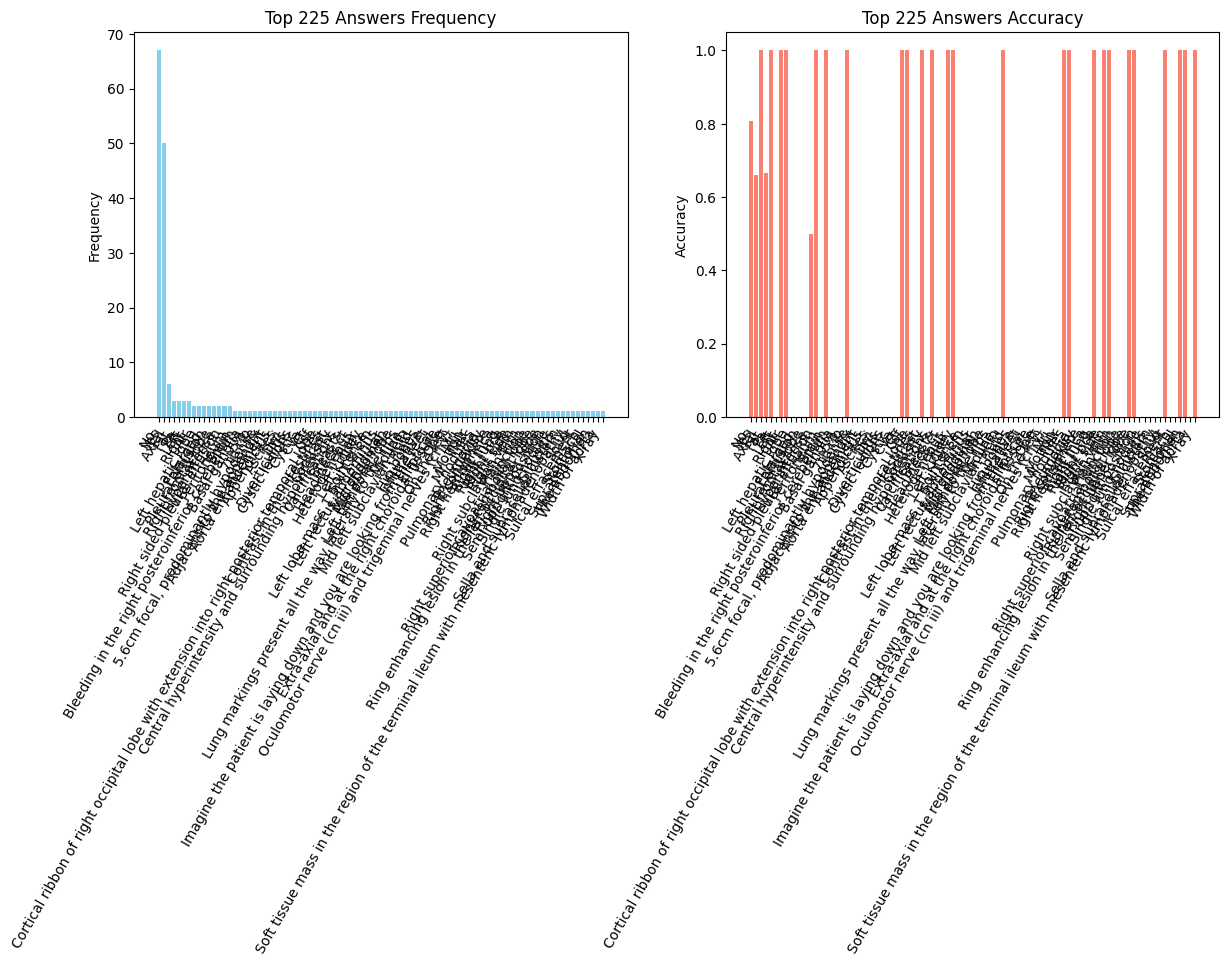

In [ ]:
import matplotlib.pyplot as plt
# ==========================================
# 7. Visualization (Charts & Images)
# ==========================================
# 7.1 Statistics Plot
# [MODIFIED] Normalize gt_answer directly to merge "no"/"No"
df_results['gt_display'] = df_results['gt_answer'].apply(lambda x: x.lower().strip().capitalize())

output_dir = "./qwen_medical_final"
stats = (
    df_results
    .groupby("gt_display")["is_correct"]
    .agg(["count", "mean"])
    .rename(columns={"count": "freq", "mean": "acc"})
    .sort_values("freq", ascending=False)
)

TOP_N = 225
top_stats = stats.head(TOP_N)

plt.figure(figsize=(14, 5))

# Frequency Plot
plt.subplot(1, 2, 1)
plt.bar(range(len(top_stats)), top_stats["freq"], color='skyblue')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Answers Frequency")

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.bar(range(len(top_stats)), top_stats["acc"], color='salmon')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.title(f"Top {TOP_N} Answers Accuracy")

plt.tight_layout()
plt.show()

# 7.2 Training History Plot
# Extracting history from trainer_state if available, or try to load log history
# Since we deleted trainer, we check the output dir for trainer_state.json
state_path = Path(output_dir) / "trainer_state.json"
history_data = []

if state_path.exists():
    with open(state_path, 'r') as f:
        data = json.load(f)
        history_data = data.get('log_history', [])
else:
    print("Warning: No trainer_state.json found. Skipping history plot.")

if history_data:
    # Filter out steps that have loss/eval_loss
    steps = []
    train_losses = []
    eval_losses = []

    # We need to align steps.
    # Log history contains mixed entries (some have loss, some have eval_loss)
    # We will just plot points as they appear

    t_steps = [x['step'] for x in history_data if 'loss' in x]
    t_loss = [x['loss'] for x in history_data if 'loss' in x]

    e_steps = [x['step'] for x in history_data if 'eval_loss' in x]
    e_loss = [x['eval_loss'] for x in history_data if 'eval_loss' in x]

    plt.figure(figsize=(10, 10))
    plt.plot(t_steps, t_loss, label='Training Loss', alpha=0.6)
    plt.plot(e_steps, e_loss, label='Validation Loss', marker='o', linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss (Qwen2-VL)')
    plt.grid(True)
    plt.show()



Generating Qualitative Examples...


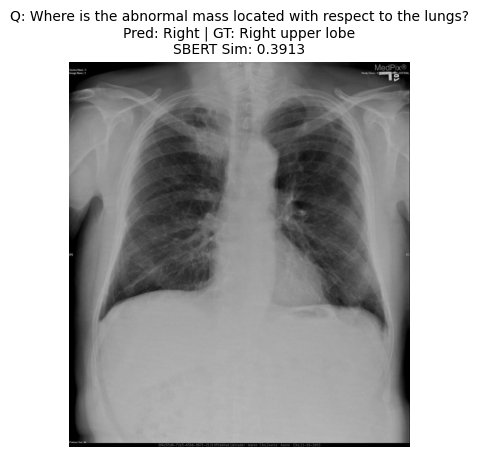

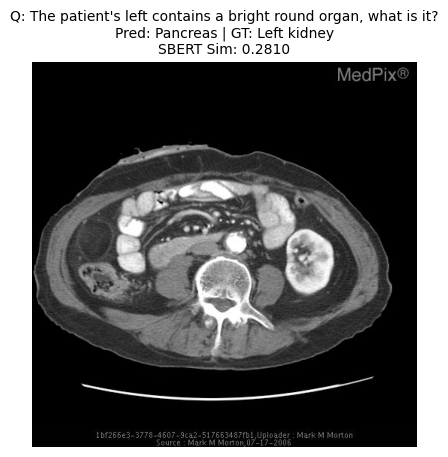

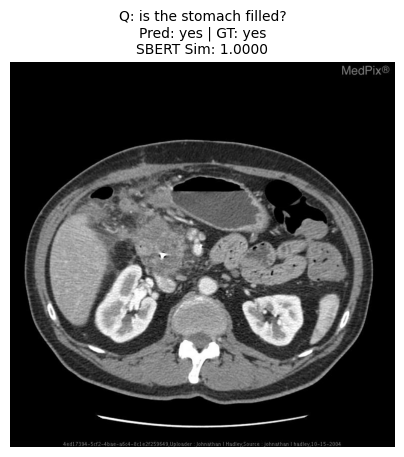

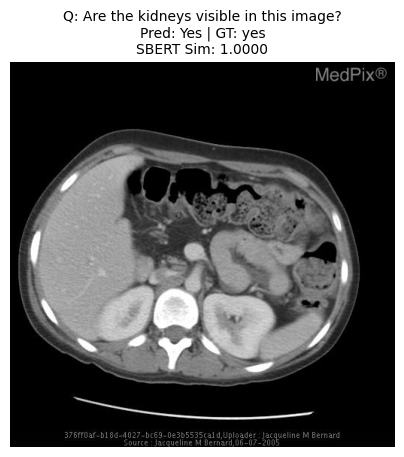

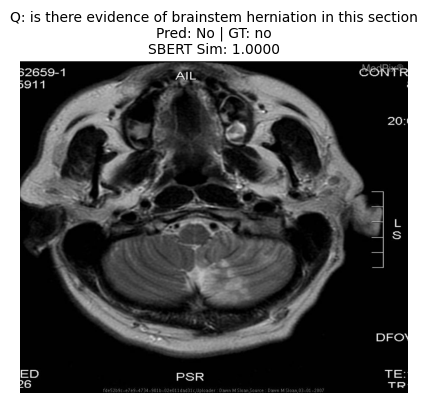

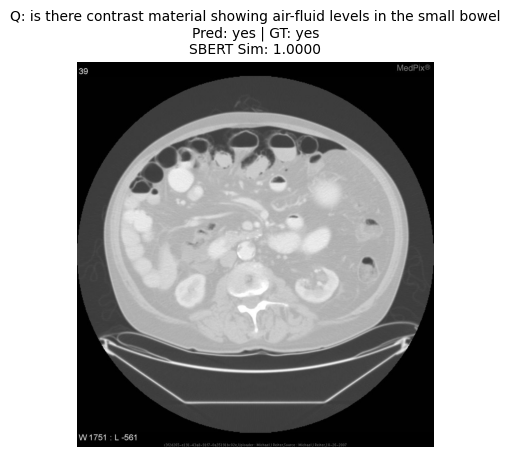

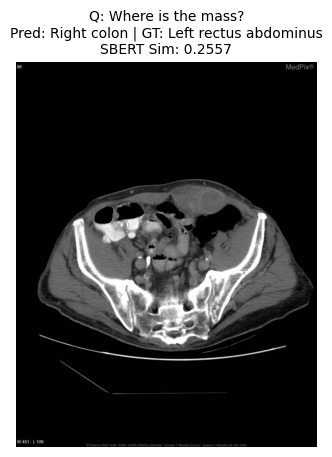

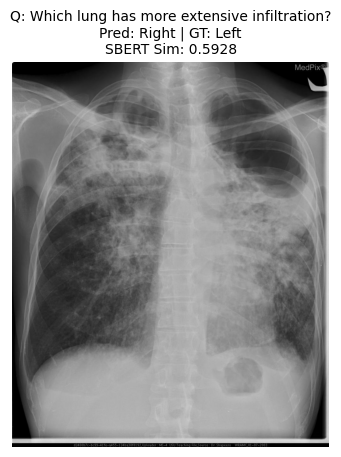

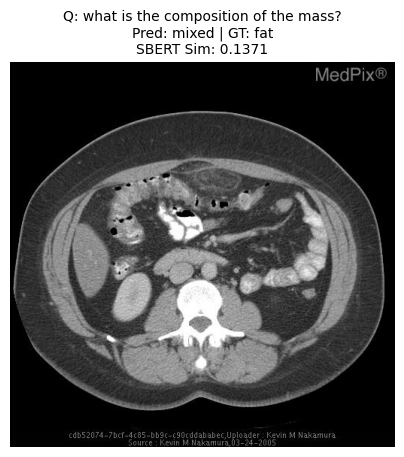

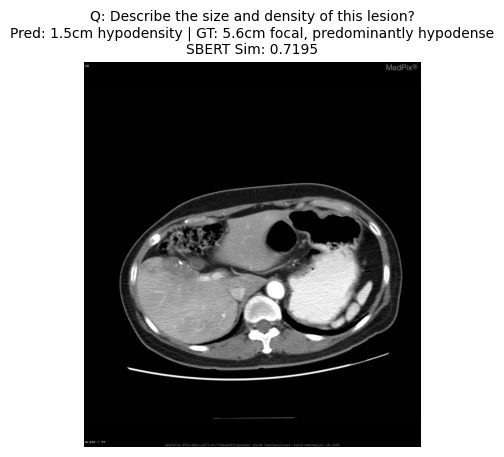

In [ ]:

# 7.3 Qualitative Results (Images & Predictions)
print("\nGenerating Qualitative Examples...")

count = 0
max_examples = 10

# Just iterate through the first few items of test_data again
for item in test_data[:max_examples]:
    image_path = item["image_path"]
    question = item["question"]
    gt_answer = item["answer"]

    # Find matching prediction from our previous loop
    # (Since we ran sequentially, we can index df_results)
    if count < len(df_results):
        row = df_results.iloc[count]
        pred_answer = row['pred_answer']
        similarity = row['similarity']

        # Display
        img = Image.open(image_path).convert("RGB")
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Q: {question}\nPred: {pred_answer} | GT: {gt_answer}\nSBERT Sim: {similarity:.4f}", fontsize=10)
        plt.axis('off')
        plt.show()

        count += 1